In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt

from models import GPT
from tokenizers import Tokenizer

from utils import BatchLoader, estimate_loss, train_loop

# hyperparameters
batch_size = 16  # number of independent sequences that'll be processed in parallel
block_size = 128  # maximum context length for the preds
max_iters = 1000
eval_interval = 200
learning_rate = 3e-4
device = "mps" if torch.backends.mps.is_available() else "cpu"
eval_iters = 200
n_embd = 128
n_head = 4
n_blocks = 4
dropout = 0.2
# --------------

torch.manual_seed(1337)

# data preparation
text = open("dataset/tinyshakespeare.txt", "r").read()
# set up the vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
tokenizer = Tokenizer(chars)

data = torch.tensor(tokenizer.encode(text), dtype=torch.long)

n = int(0.9 * len(data))  # first 90% will be the training set
n1 = int(0.98 * len(data))  # 90-98% will be the validation set and the last 2% will be the calibration set for the paper

train_data = data[:n]
val_data = data[n:n1]
calibrate_data = data[n1:]

train_loader = BatchLoader(train_data, block_size, batch_size, device, name="train")
val_loader = BatchLoader(val_data, block_size, batch_size, device, name="val")
calibration_loader = BatchLoader(calibrate_data, block_size, batch_size, device, name="calibrate")


UNIFORM BASELINE:  4.174387454986572


step 800: train loss 2.3588, val loss 2.3563: 100%|██████████| 1000/1000 [01:10<00:00, 14.09it/s]


training is done!

SAndy eam, he yleshe q-Mof the, tat fond?
HOUS Ancak be's hy I towabloghe s tinge k: douly the f
Tanigouait ine k eye shave
Goou mesoel th tho br fice t wikis crn I Loseipoulisse h'ty s:
Thay,
Thindla beshorgrve ian merot.
Ang, hing, f o wat Lro ands, o,
Werenn Grenofy?
Whe Shen: hily irffatheuas s, thons! ig desis
Thin I t wencoupean, her sof:
Car Fine's ussendes;
Tour s I dinsry thixerds he at d kenin hacheavilon.


Goun:
ULhich taceil m; adisen hty t the st.
JUikimap-

Tik fe INCe, tho wownov


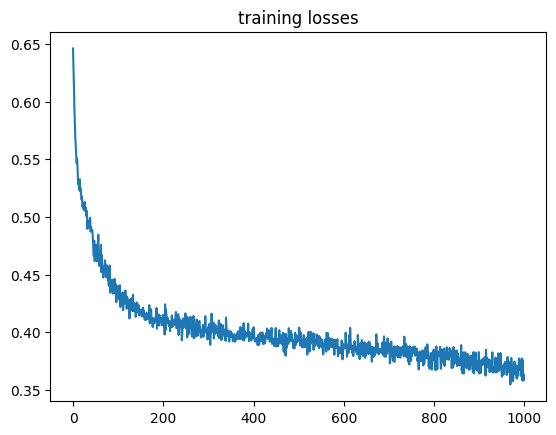

In [10]:
model = GPT(vocab_size, block_size, n_embd, n_head, n_blocks, device, dropout)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

training_losses = train_loop(model, optimizer, vocab_size, train_loader, [train_loader, val_loader], max_iters, eval_interval, eval_iters)

print("training is done!")

plt.title("training losses")
plt.plot(training_losses)
plt.savefig("training_losses.png")

idx = torch.zeros((1, 1), dtype=torch.long, device=device)
print(tokenizer.decode(model.generate(idx, max_new_tokens=500)[0].tolist()))

In [14]:
from utils import save

model_params = {
    "vocab_size": vocab_size,
    "block_size": block_size,
    "n_embd": n_embd,
    "n_head": n_head,
    "n_blocks": n_blocks,
    "dropout": dropout,
    "device": device
}

save(model, tokenizer, model_params, "model")

In [2]:
from utils import load

In [3]:
loaded_model, tokenizer = load(GPT, "model")
loaded_model.to(device);

/Users/alperiox/Desktop/coding/paper-implts/Compact_Language_Models_240714679/utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(sav

In [33]:
def attn_head_importance_hook(module, ins, outs) -> None:
    """ calculates the multi-head-attention layer's importance per head """

    # outs.shape = (B, T, E) where B: batch_size, T: num tokens, E: embedding size
    # the importance is calculated as summing the L2 norm of the attn outputs on B and T dimensions
    outs_flat = outs.view(-1, outs.shape[-1]) # (b,t,e) -> (b*t, e)
    print(outs_flat.shape)
    importance = torch.linalg.vector_norm(outs_flat.detach().cpu(), ord=2, dim=-1).sum().item()
    print("module:", module.__class__.__name__, end=" ")
    print("importance:", importance)
 

def neuron_importance_hook(module, ins, outs) -> None:
    """ calculates the neuron importance for the given layer """ 
    
    # for each neuron in the ffwd layer, we will simply sum up the output columns
    # as they're the activations of individual neurons
    # calculate the importances
    # importance = outs.detach().sum()
    importance = outs.detach().cpu().sum(dim=(0,1))
    print(ins)
    print(f"{module.__class__.__name__} importance.shape: {importance.shape}")


def embedding_importance_hook(module, ins, outs) -> None:
    # the first block's first processing layer will be the 
    # layer norm,
    # so we'll just sum up the layer norm outputs after getting them
    print("module:", module.__class__.__name__)
    print("outs.shape:", outs.shape) # probably (B, T, E)
    # calculate the importances
    importance = outs.detach().sum(dim=-1)
    print("importance.shape:", importance.shape)
    print("n_embd: ", outs.size(-1))

def block_importance_hook(module, ins, outs) -> None:
    print("module:", module.__class__.__name__)
    print("outs.shape:", outs.shape) # probably (B, T, E)
    in_vectors = ins[0].detach().view(-1, ins[0].shape[-1])
    out_vectors = outs.detach().view(-1, outs.shape[-1])
    block_importance = in_vectors.T @ out_vectors
    print("importance.shape:", block_importance.shape)
    print("n_embd: ", outs.size(-1))


for k in loaded_model.blocks[0].sa._forward_hooks:
    loaded_model.blocks[0].sa._forward_hooks.pop(k)

for k in loaded_model.blocks[0].ffwd._forward_hooks:
    loaded_model.blocks[0].ffwd._forward_hooks.pop(k)

for k in loaded_model.blocks[0].ln1._forward_hooks:
    loaded_model.blocks[0].ln1._forward_hooks.pop(k)

for k in loaded_model.blocks[0]._forward_hooks:
    loaded_model.blocks[0]._forward_hooks.pop(k)


loaded_model.blocks[0].sa.register_forward_hook(attn_head_importance_hook)
loaded_model.blocks[0].ffwd.register_forward_hook(neuron_importance_hook)
loaded_model.blocks[0].ln1.register_forward_hook(embedding_importance_hook)
loaded_model.blocks[0].register_forward_hook(block_importance_hook)

In [34]:
x = torch.randint(0, 10, (2, 4, 6))
w = torch.randint(0, 10, (6, 3))

y1 = x @ w
y2 = x @ w[:, 0]

s = []
for k in range(3):
    s.append((x @ w[:, k]).sum())
s = torch.tensor(s)


y1[:, :, 0], y2, s, y1.sum(dim=(0,1))

(tensor([[111, 174, 238, 103],
         [199, 260, 209, 202]]),
 tensor([[111, 174, 238, 103],
         [199, 260, 209, 202]]),
 tensor([1496, 1225,  961]),
 tensor([1496, 1225,  961]))

In [35]:
m = torch.randn((20, 128))
x = torch.randn((3, 5, 128))

y = x@m.T

y.shape

torch.Size([3, 5, 20])

In [36]:
loaded_model(torch.randn(2, 8, dtype=torch.long, device=device))

module: LayerNorm
outs.shape: torch.Size([2, 8, 128])
importance.shape: torch.Size([2, 8])
n_embd:  128
torch.Size([16, 128])
module: MultiHeadAttentionConcat importance: 151.79104614257812
(tensor([[[ 0.6599,  0.7853,  0.6889,  ...,  0.5581, -1.0037,  1.4915],
         [ 0.0401, -0.2324,  0.2974,  ...,  0.3144,  0.0932,  1.4995],
         [-1.9352,  0.6888,  0.6970,  ..., -0.6637, -1.6084,  1.1890],
         ...,
         [-0.5597,  0.3585, -0.2427,  ..., -0.4912, -1.1311,  0.3630],
         [ 0.9800,  0.8243, -0.6411,  ..., -0.5979, -1.3432,  0.4650],
         [-0.2845,  0.8167, -0.3742,  ..., -0.8224, -1.5713,  1.5798]],

        [[ 0.8205,  0.5398,  0.2728,  ...,  0.0819, -0.9970,  1.3318],
         [ 0.1172, -0.2458, -0.0057,  ...,  0.7019,  0.1396,  1.2225],
         [-1.3951,  1.2266, -0.9442,  ...,  0.0836, -3.0649,  1.2973],
         ...,
         [-0.6003,  0.3361, -0.6198,  ..., -0.6826, -0.6916,  0.2086],
         [ 1.1893,  0.8213, -0.8363,  ..., -0.2074, -1.3446,  0.1181]

(tensor([[[-0.2508, -0.2674, -2.4366,  ..., -2.0396, -1.7642, -2.3493],
          [-2.0421, -0.8918, -2.9208,  ..., -2.2555, -0.5106, -2.2284],
          [-3.8820, -2.9830, -4.1894,  ..., -2.0462,  1.3414, -2.1536],
          ...,
          [ 0.2338, -1.9339, -3.1861,  ..., -2.2207, -1.3555, -2.0824],
          [-0.8399, -1.9798, -3.3365,  ..., -1.3196, -1.1593, -1.5096],
          [-1.5799, -2.0011, -3.1129,  ..., -1.7136, -0.4669, -1.6718]],
 
         [[-0.4424, -0.8608, -2.8484,  ..., -1.4016, -1.6610, -1.6147],
          [-0.2605,  0.0236, -2.6321,  ..., -1.5034, -2.4286, -1.5927],
          [-1.4772, -1.6772, -3.0598,  ..., -1.3149, -1.1022, -1.3019],
          ...,
          [ 0.1843, -1.0123, -2.9234,  ..., -1.3350, -1.5871, -1.4783],
          [-1.3902, -1.4150, -2.9279,  ..., -1.5637, -1.3249, -1.8193],
          [-2.3254, -2.4441, -2.8694,  ..., -1.3312, -0.9573, -1.6196]]],
        device='mps:0', grad_fn=<LinearBackward0>),
 None)